making catalogues to test within eazy
opens ZFOURGE cat file, prepares it for dataframe, and some different catalogues are made (binning and such)
then these are saved and can be used within the eazy code
Best to run this as seprarate cells, specified to your requirements

In [1]:
%matplotlib inline

import os
import glob
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from astropy.utils.exceptions import AstropyWarning
import time
import importlib
import sys
import eazy
import astropy.stats


field = 'cdfs'
output = 'inputs/alternate_catalogues/'

In [6]:
# Adapting Template Files for EAZY

# Set the directory
in_dir = 'G:/AGN/hlsp_agnsedatlas_multi_multi_all_multi_v1_collection/templates_restframe/'
out_dir = 'C:/Users/eddie/PycharmProjects/SEDTemplate_conda/templates/hlsp_agnsedatlas_rest_composite/'


if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Get the txt files  in the directory
txt_files = glob.glob(in_dir + '*.txt')

txt_files = [i for i in txt_files if 'central' in i] # If you want the composite files

for i in txt_files:

    # Read the txt file
    data = pd.read_csv(i, sep=" ", comment='#', header=None, skipinitialspace=True)

    data[0] = data[0] * 1e4 # Convert the wavelength from Micron to Angstroms
    output_data = data[[0,2]]

    # Get the base name of the txt file
    base_name = os.path.basename(os.path.splitext(i)[0])

    # Write the selected data to a dat file
    output_data.to_csv(out_dir + f'{base_name}.dat', sep=' ', index=False, header=False)


In [2]:
# Load the catalogues

os.getcwd()

# Get all cat files
all_files = glob.glob(f'zfourge/{field}/{field}*.cat')

# Check if any files were found
if not all_files:
  print("No .cat files found")
else:
  # Find the shortest file by filename (assuming filename reflects size)
  main_dir = min(all_files, key=len)

main = pd.read_csv(main_dir, sep=" ", comment="#", header=None)
headers = pd.read_csv(main_dir, sep=" ", header=None, nrows=1).iloc[0]
headers = headers[1:]
main.columns = headers

agn_data1 = glob.glob(f'zfourge/{field}/{field}.v*.agn.*cat')
agn = pd.read_csv(agn_data1[0], sep="\s+", comment='#', header=None)
headers = ['id', 'ir_agn', 'radio_agn','xray_agn']
agn.columns = headers


merged = pd.merge(main, agn, on='id', how='left')
unwanted_hash = pd.Series(np.nan, index=merged.index, dtype=float)
merged.insert(loc=0, column='#', value=unwanted_hash) #wierd hash at the start

Doing Specific Range Cuts

In [59]:
object_range = (0,-0)
new_cat = merged[object_range[0]:object_range[1]]
new_cat.to_csv(f'{output}{field}.range.{object_range}.cat', sep=' ', index=False)

Doing Standard AGN Type Cuts, AGN type (Or wavelength) is not really as useful as the fraction of AGN

In [16]:
# ir_cut = merged[(merged['ir_agn'] == 1) & (merged['z_spec'] > 0)]
# radio_cut = merged[(merged['radio_agn'] == 1) & (merged['z_spec'] > 0)]
# xray_cut = merged[(merged['xray_agn'] == 1) & (merged['z_spec'] > 0)]
# all_cut = merged[(merged['ir_agn'] == 1) & (merged['z_spec'] > 0) | (merged['radio_agn'] == 1) & (merged['z_spec'] > 0) | (merged['xray_agn'] == 1) & (merged['z_spec'] > 0)]
# nothing_cut = merged[(merged['ir_agn'] != 1) & (merged['radio_agn'] != 1) & (merged['xray_agn'] != 1) & (merged['z_spec'] > 0)]

ir_cut = merged[(merged['ir_agn'] == 1)]
radio_cut = merged[(merged['radio_agn'] == 1)]
xray_cut = merged[(merged['xray_agn'] == 1)]
all_cut = merged[(merged['ir_agn'] == 1) | (merged['radio_agn'] == 1) | (merged['xray_agn'] == 1)]
nothing_cut = merged[(merged['ir_agn'] != 1) & (merged['radio_agn'] != 1) & (merged['xray_agn'] != 1)]

ir_cut.to_csv(f'{output}{field}.ir_agn.cat', sep=' ', index=False)
radio_cut.to_csv(f'{output}{field}.radio_agn.cat', sep=' ', index=False)
xray_cut.to_csv(f'{output}{field}.xray_agn.cat', sep=' ', index=False)
all_cut.to_csv(f'{output}{field}.all_agn.cat', sep=' ', index=False)
nothing_cut.to_csv(f'{output}{field}.no_agn.cat', sep=' ', index=False)

Reading the AGN Fraction file, and slimming it down, and creating keys from it

In [17]:
agn_per_dir = 'inputs/results.txt' # THIS IS JUST CDFS, and a very big file
all_bayes = pd.read_csv(agn_per_dir, sep="\s+", comment='#')

In [18]:
new_bayes = all_bayes[['id', 'bayes.agn.fracAGN', 'bayes.agn.fracAGN_err', 'bayes.agn.luminosity']] # this is the information I want from this file
new_bayes.to_csv(f'inputs/cdfs_agn_frac.txt', sep=' ', index=False)

In [4]:
bayes = pd.read_csv('inputs/cdfs_agn_frac.txt', sep="\s+", comment='#')
merged_bayes = pd.merge(merged, bayes, on='id', how='left')
fraction_sorted = merged_bayes.sort_values(by='bayes.agn.fracAGN', ascending=False)
luminosity_sorted = merged_bayes.sort_values(by='bayes.agn.luminosity', ascending=False)
num_rows = merged_bayes.shape[0]

In [22]:
num_bins = 3

bins_frac = pd.cut(fraction_sorted['bayes.agn.fracAGN'], num_bins, labels=False)
fraction_sorted['bin'] = bins_frac + 1
bins_lum = pd.cut(luminosity_sorted['bayes.agn.luminosity'], num_bins, labels=False)
luminosity_sorted['bin'] = bins_lum + 1

#split fraction sorted into bins and save each as a separate df


for bin_label in fraction_sorted['bin'].unique():
  bin_df = fraction_sorted.query("bin == @bin_label")  # Filter by bin label
  bin_df = bin_df.drop(columns=['bin', 'bayes.agn.fracAGN', 'bayes.agn.fracAGN_err', 'bayes.agn.luminosity'])  # Drop the bin column
  bin_df.to_csv(f'{output}{field}.fraction.bin{bin_label}.cat', sep=' ', index=False)

for bin_label in luminosity_sorted['bin'].unique():
    bin_df = luminosity_sorted.query("bin == @bin_label")  # Filter by bin label
    bin_df = bin_df.drop(columns=['bin', 'bayes.agn.fracAGN', 'bayes.agn.fracAGN_err', 'bayes.agn.luminosity'])  # Drop the bin column
    bin_df.to_csv(f'{output}{field}.luminosity.bin{bin_label}.cat', sep=' ', index=False)


In [15]:
#Only objects with a agn fraction above 0
percent = 0.10
only_agn = merged_bayes[merged_bayes['bayes.agn.fracAGN'] > percent]
print(len(only_agn))
only_agn.to_csv(f'{output}{field}.only_agn_above_{percent}.cat', sep=' ', index=False)

17920


Lacy wedge

In [56]:
lacy_df = pd.DataFrame()
lacy_df['58'] = merged['f_IRAC_58']
lacy_df['36'] = merged['f_IRAC_36']
lacy_df['80'] = merged['f_IRAC_80']
lacy_df['45'] = merged['f_IRAC_45']

lacy_df = lacy_df[(lacy_df['58'] > 0) & (lacy_df['36'] > 0) & (lacy_df['80'] > 0) & (lacy_df['45'] > 0)]

lacy_df['x'] = np.log10(lacy_df['58']/lacy_df['36'])
lacy_df['y'] = np.log10(lacy_df['80']/lacy_df['45'])

cut = (lacy_df['x'] > -0.1) & (-0.2 < lacy_df['y']) & (lacy_df['y'] < (0.8 * lacy_df['x'] + 0.5))
lacy_in = lacy_df[cut]

common_index = merged.index.intersection(lacy_in.index)
lacy_cat = merged.loc[common_index]

lacy_out = lacy_df[(lacy_df['x'] < -0.1) | (lacy_df['y'] < -0.2) | (lacy_df['y'] > (0.8 * lacy_df['x'] + 0.5))]

lacy_cat.to_csv(f'{output}{field}.lacy_wedge.cat', sep=' ', index=False)

(-1.2, 1.2)

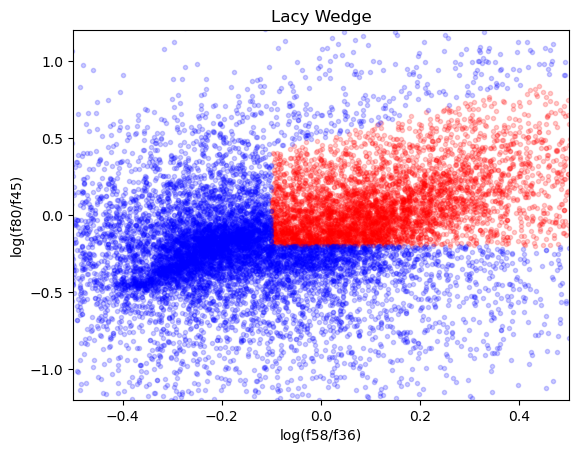

In [53]:
plt.scatter(lacy_in['x'], lacy_in['y'], c='red', marker='.', alpha=0.2)
plt.scatter(lacy_out['x'], lacy_out['y'], c='blue', marker='.', alpha=0.2)
plt.xlabel('log(f58/f36)')
plt.ylabel('log(f80/f45)')
plt.title('Lacy Wedge')
plt.xlim(-0.5, 0.5)
plt.ylim(-1.2, 1.2)